<a href="https://colab.research.google.com/github/MoustafaSeddik/Hyperparamters-Tuning/blob/main/Ray_Tuna_for_L_R_NN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters Tuning with Ray Tune

In [ ]:
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 11.6 MB/s eta 0:00:00


## Import Libiraies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
import numpy as np

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler # An example scheduler
from ray.tune import CLIReporter # For better console output
from ray import train # Import train context
from ray.train import Checkpoint # Updated way to handle checkpoints

from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


## 1. Define the Neural Network Model (PyTorch)

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(LinearRegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RegressionNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 2. Create a Training Function (Trainable)

### Data Engineering

In [ ]:
# --- Data Generation (Simple y = 2x + 1 + noise) ---
train_sample = 1000
val_sample = 250

X_train = torch.randn(train_sample, 1) * 15 # 100 samples, 1 feature
y_train = 2 * X_train + 1 + torch.randn(train_sample, 1) *15

X_val = torch.randn(val_sample, 1) * 15   # 50 validation samples
y_val = 2 * X_val + 1 + torch.randn(val_sample, 1) * 15

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: torch.Size([1000, 1])
y_train shape: torch.Size([1000, 1])
X_val shape: torch.Size([250, 1])
y_val shape: torch.Size([250, 1])


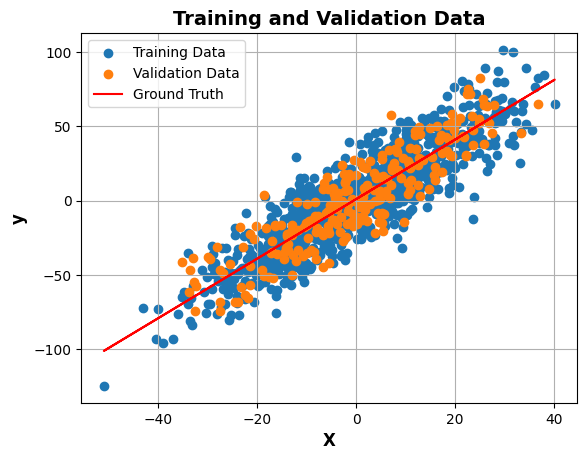

In [ ]:
# Ploting data
plt.scatter(X_train.numpy(), y_train.numpy(), label='Training Data')
plt.scatter(X_val.numpy(), y_val.numpy(), label='Validation Data')
plt.plot(X_train.numpy(), 2 * X_train.numpy() + 1, color='red', label='Ground Truth')
plt.xlabel('X', fontsize=12, fontweight= 'bold')
plt.ylabel('y', fontsize=12, fontweight= 'bold')
plt.title('Training and Validation Data', fontsize=14, fontweight= 'bold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

print(f"length train_dataset: {len(train_dataset)}")
print(f"length val_dataset: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=int(5), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=int(5))

print(f"length train_loader: {len(train_loader)}")
print(f"length val_loader: {len(val_loader)}")


length train_dataset: 1000
length val_dataset: 250
length train_loader: 200
length val_loader: 50


### Training Function

In [ ]:
def train_linear_regression(config):
    """
    Trainable function for Ray Tune.

    Args:
        config (dict): Dictionary of hyperparameters with expected keys:
        "lr", "batch_size", "hidden_size", "epochs".

    Returns:
        train_loss_history (list): List of training loss values for each epoch.
        val_loss_history (list): List of validation loss values for each epoch.
    """
    lr = config["lr"]
    batch_size = config["batch_size"]
    num_epochs = config.get("epochs", 50)
    # Default to 10 epochs if not specified
    # If the key "epochs" is not found in the config dictionary
    # (which shouldn't happen in this notebook's setup since "epochs" is
    # explicitly in the search_space), the default value of 100 is used.
    hidden_size = config["hidden_size"]
    num_layers = config.get("num_layers", 1)
    # Default to 1 layer if not specified

    # --- Data Generation (Simple y = 2x + 1 + noise) ---
    train_sample = 1000
    val_sample = 250

    X_train = torch.randn(train_sample, 1) * 25 # 100 samples, 1 feature
    y_train = 2 * X_train + 1 + torch.randn(train_sample, 1) * 25

    X_val = torch.randn(val_sample, 1) * 15   # 50 validation samples
    y_val = 2 * X_val + 1 + torch.randn(val_sample, 1) * 15

    # Ensure batch size does not exceed validation samples for val_loader
    #val_batch_size = min(int(config["batch_size"]), len(val_dataset))

    train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(batch_size))

    # --- Model, Optimizer, Loss ---
    # Use hidden_size from config
    #model = LinearRegressionModel(input_size=1, output_size=1, hidden_size=hidden_size)
    model = RegressionNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=config["weight_decay"])

    # --- Training Loop ---
    val_loss_history = []
    train_loss_history = []
    best_loss = np.inf  # init to infinity
    best_model = None
    print(f"Start training with Num_epochs= {num_epochs}")

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_loss = 0.0, 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1

        train_loss = running_loss / epoch_steps
        train_loss_history.append(train_loss)
        #print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}")

        # --- Validation Loop ---
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        if avg_val_loss < best_loss:
          best_loss = avg_val_loss
          best_model = copy.deepcopy(model)
          print(f"The best model is Found with validation loss= {best_loss:.4e}")

        # --- Report metrics to Ray Tune ---
        train.report({"mean_loss": avg_val_loss, "train_loss": train_loss ,"epoch": epoch}) # Report validation loss

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} - validation loss: {avg_val_loss:.4f}")

    print(f"Finished Training for config: {config}. min MSE: {min(val_loss_history)}")

    return train_loss_history, val_loss_history, best_model


##3. Define the Hyperparameter Search Space

In [ ]:
#search_space = {
#    "lr": tune.loguniform(1e-5, 1e-1),  # Learning rate between 0.0001 and 0.1
#    "batch_size": tune.choice([2**i for i in range(9)]), # Discrete choices for batch size
#    "epochs": tune.choice([50, 100, 150]), # Number of training epochs
#    "hidden_size": tune.randint(8, 512) # Example if you had hidden layers
#}

## 4. Configure and Run the Tuning Process

In [ ]:
def run_tuning(search_space):
    # Initialize Ray (if not already initialized)
    if not ray.is_initialized():
      #Initializes Ray. num_cpus tells Ray how many CPU cores it can utilize for parallel trials. Adjust this based on your machine.
      ray.init(ignore_reinit_error=True, num_cpus=4) # Adjust num_cpus as per your machine

    # Reporter for command-line output, Provides nicely formatted progress updates in your console during the tuning process.
    reporter = CLIReporter(
        metric_columns=["mean_loss", "training_iteration", "epoch", "train_loss"],
        #specifies which metrics reported by your training function (train_linear_regression) should be displayed in the console output.
        parameter_columns=["lr", "batch_size", "epochs", "hidden_size"],
        #specifies which hyperparameters from the search_space should be displayed for each trial in the console output.
        max_progress_rows=50,
        # limits the number of trial rows displayed in the console output at any given time.
        sort_by_metric=True)

    # Scheduler (optional, for early stopping, etc.)
    # ASHAScheduler stops unpromising trials early.
    scheduler = ASHAScheduler(
        metric="mean_loss", # The metric it monitors (must match what you report).
        mode="min", # It tries to minimize this metric.
        max_t= 100,  # Max number of epochs/iterations a trial can run (should match max epochs)
        grace_period=25, # Minimum number of iterations before stopping
        reduction_factor=2) # How aggressively to prune trials.

    #
    hyperopt_search = HyperOptSearch(search_space, metric="mean_loss", mode="min")

    # Using the new `Tuner` API (recommended)
    tuner = tune.Tuner(
        tune.with_resources(train_linear_regression,{"cpu": 3, "gpu": 0.9 if torch.cuda.is_available() else 0}), # Allocate 1 CPU per trial
        # Wraps your training function and specifies the resources
        #(e.g., 1 CPU, optionally GPUs like {"gpu": 0.5}) to allocate for each trial.
        param_space=search_space,
        tune_config= tune.TuneConfig(scheduler=scheduler,     # The trial scheduler
                                    num_samples=50,           # Number of different hyperparameter combinations to try
                                    #search_alg=hyperopt_search,
                                    ),

        run_config=ray.train.RunConfig( # Use train.RunConfig for reporters, storage, etc.
            name="linear_regression_tuning",
            progress_reporter=reporter,
            # storage_path="/tmp/ray_results", # Optional: specify where to store results
        )
    )

    results = tuner.fit()
    #This line starts the hyperparameter tuning process. Ray Tune will now
    #run num_samples trials, each with a different hyperparameter configuration

    best_result = results.get_best_result(metric="mean_loss", mode="min")
    print("\n" + "="*100)
    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["mean_loss"]))

    # Example: Load the best model checkpoint if you saved it
    # best_checkpoint = best_result.checkpoint
    # if best_checkpoint:
    #     model_state, optimizer_state = torch.load(best_checkpoint.to_directory() + "/checkpoint.pt")
    #     # ... then load into your model ...
    # else:
    #     print("No checkpoint found for the best trial.")

    ray.shutdown()

    return results


## 5. Analyze Results

In [ ]:
search_space = {
    "lr": tune.loguniform(1e-5, 1e-1),  # Learning rate between 0.0001 and 0.1
    "batch_size": tune.choice([8, 16, 32, 64]), # Discrete choices for batch size
    "epochs": 100 , # Number of training epochs. Also could be tune.choice([50, 75, 100])
    "hidden_size": tune.randint(8, 512), # Example if you had hidden layers
    "weight_decay": tune.loguniform(1e-6, 1e-3),
    "num_layers": tune.choice([2, 3, 4, 5, 6])
}

results = run_tuning(search_space)

2025-05-30 20:28:28,726	INFO worker.py:1888 -- Started a local Ray instance.
2025-05-30 20:28:30,625	WARNING hyperopt_search.py:193 -- You passed a `space` parameter to <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> that contained unresolved search space definitions. <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
2025-05-30 20:28:30,691	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+-------------------------------------------------------------+
| Configuration for experiment     linear_regression_tuning   |
+-------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator      |
| Scheduler                        AsyncHyperBandScheduler    |
| Number of trials                 50                         |
+-------------------------------------------------------------+

View detailed results here: /root/ray_results/linear_regression_tuning
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-05-30_20-28-27_208424_325/artifacts/2025-05-30_20-28-30/linear_regression_tuning/driver_artifacts`

Trial status: 50 PENDING
Current time: 2025-05-30 20:28:31. Total running time: 0s
Logical resource usage: 3.0/4 CPUs, 0.9/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------+

2025-05-30 20:41:08,150	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/linear_regression_tuning' in 0.0311s.



Trial train_linear_regression_a6882_00049 completed after 25 iterations at 2025-05-30 20:41:08. Total running time: 12min 37s
+--------------------------------------------------------------+
| Trial train_linear_regression_a6882_00049 result             |
+--------------------------------------------------------------+
| checkpoint_dir_name                                          |
| time_this_iter_s                                     0.30535 |
| time_total_s                                         9.66819 |
| training_iteration                                        25 |
| epoch                                                     24 |
| mean_loss                                            576.245 |
| train_loss                                            572.05 |
+--------------------------------------------------------------+

Trial status: 50 TERMINATED
Current time: 2025-05-30 20:41:08. Total running time: 12min 37s
Logical resource usage: 3.0/4 CPUs, 0.9/1 GPUs (0.0/1.0 accelera

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

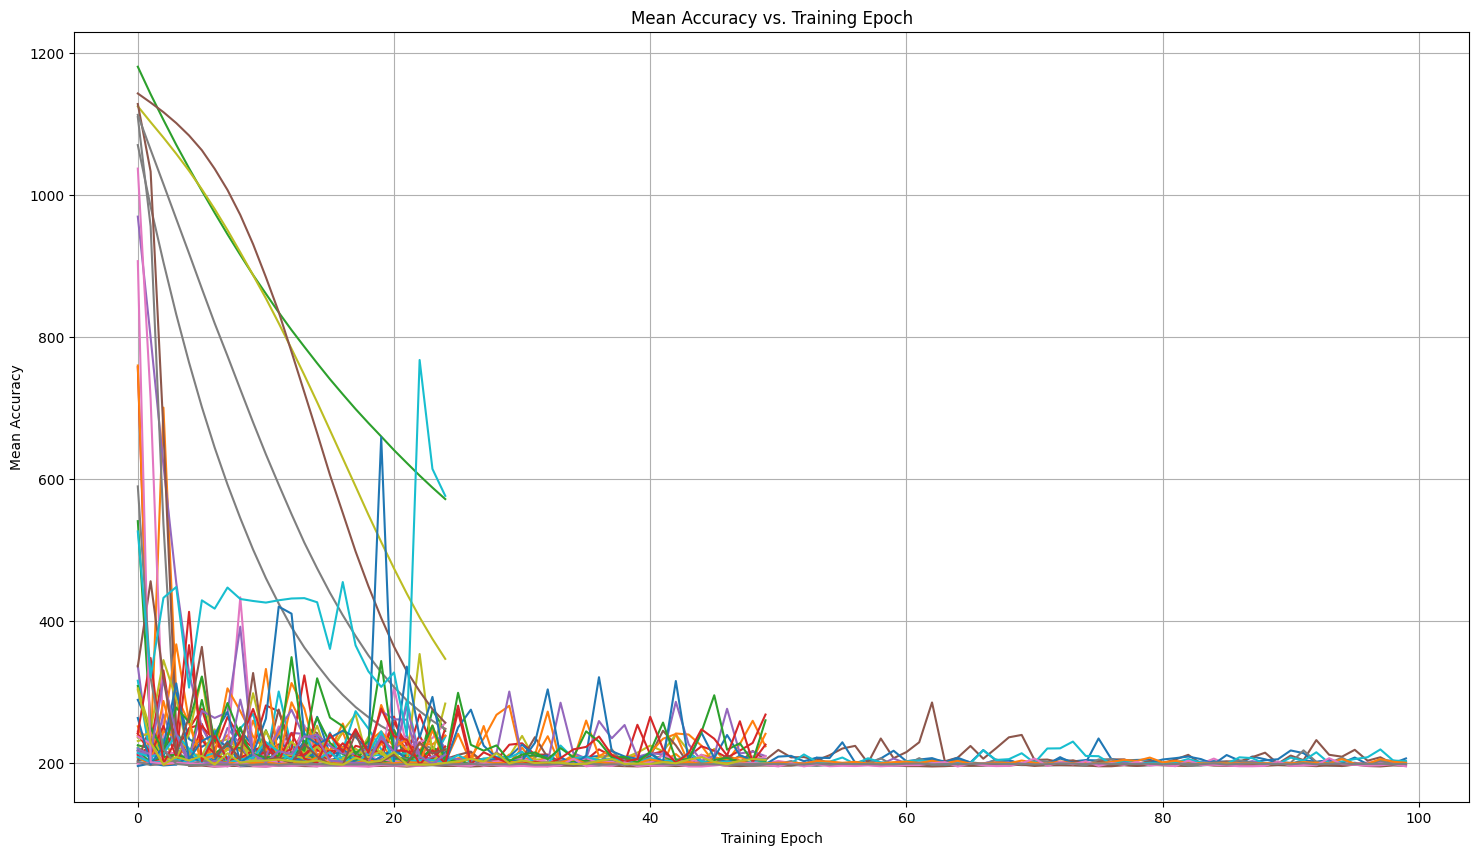

In [ ]:
# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.path: result.metrics_dataframe for result in results}
# Plot by epoch
plt.figure(figsize=(18, 10))
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_loss.plot(ax=ax, legend=False)
ax.set_xlabel("Training Epoch")
ax.set_ylabel("Mean Accuracy")
ax.set_title("Mean Accuracy vs. Training Epoch")
ax.grid(True)

Available columns: Index(['mean_loss', 'train_loss', 'epoch', 'timestamp', 'checkpoint_dir_name',
       'done', 'training_iteration', 'trial_id', 'date', 'time_this_iter_s',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'iterations_since_restore', 'config/lr', 'config/batch_size',
       'config/epochs', 'config/hidden_size', 'config/weight_decay',
       'config/num_layers', 'logdir'],
      dtype='object')
Metrics keys in best result: dict_keys(['mean_loss', 'train_loss', 'epoch', 'timestamp', 'checkpoint_dir_name', 'done', 'training_iteration', 'trial_id', 'date', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'experiment_tag'])


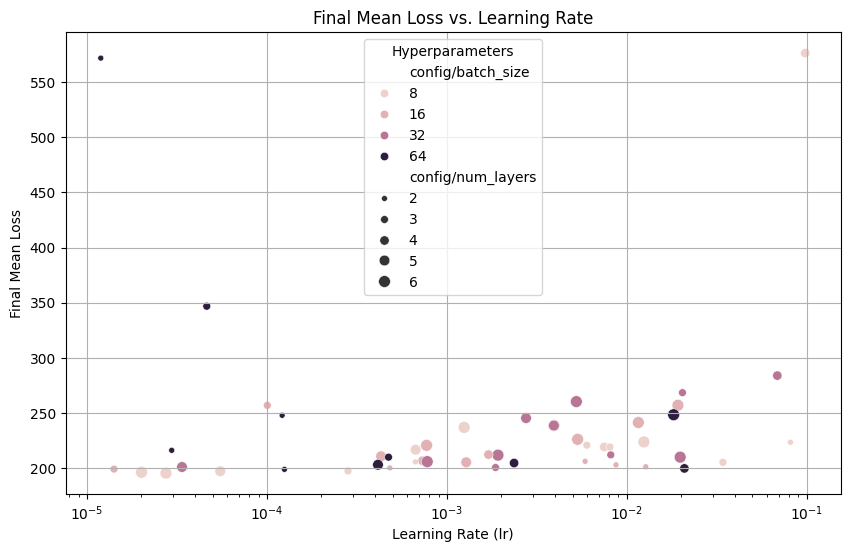

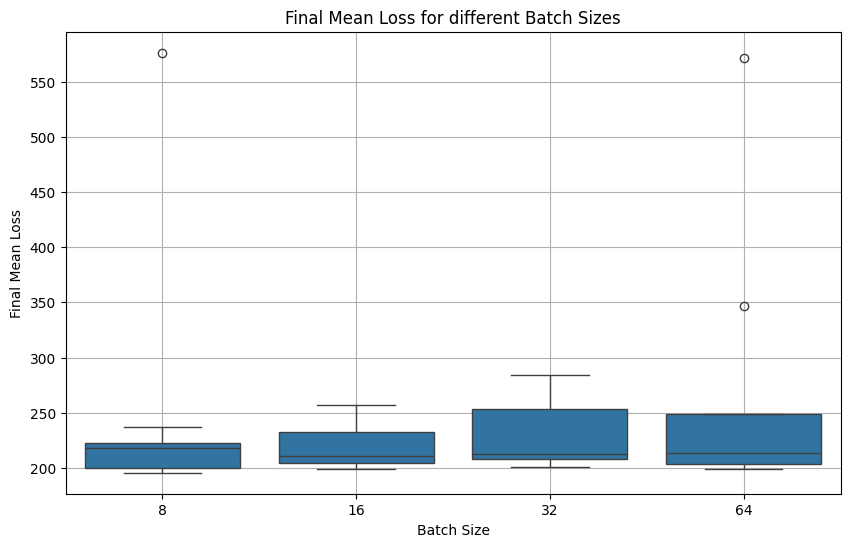

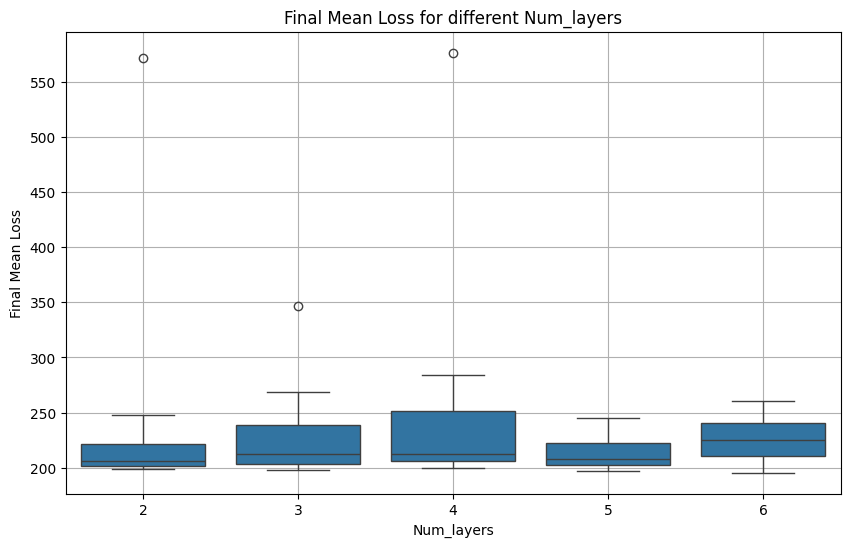

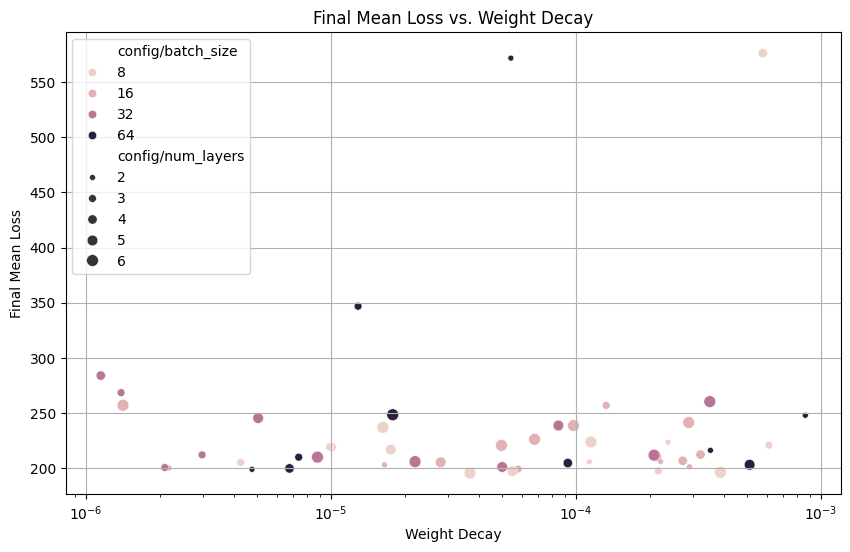

In [ ]:
# Assuming 'results' is the object from tuner.fit() from the previous example
# results = tuner.fit() # This would have been run already

# Get all results as a list of dictionaries (or directly to DataFrame)
# Each item in the list corresponds to a trial result.
# The trial's config and last reported metrics are available.

# Option 1: Get a DataFrame directly
df_results = results.get_dataframe()

# The DataFrame will contain columns for each hyperparameter in your search space,
# the reported metrics (like 'mean_squared_error', 'epoch', 'timestamp', 'time_this_iter_s', etc.),
# and other information like 'logdir', 'trial_id'.

# Let's print the relevant columns to see
print("Available columns:", df_results.columns)
# You might want to select specific columns for clarity:
# Example: selecting hyperparameters and the final reported metric
# Note: The metric column name might be exactly 'mean_squared_error' or
# it might be nested if you reported multiple things.
# If you reported {'mean_squared_error': value, 'epoch': e}, then after
# get_dataframe(), you might have a column named 'mean_squared_error'.
# Let's check the best result's metrics to be sure of the name:

# Fix: Provide metric and mode to get_best_result()
best_result_check = results.get_best_result(metric="mean_loss", mode="min")

if best_result_check:
    print("Metrics keys in best result:", best_result_check.metrics.keys())
    # Use the metric name that you reported in train.report()
    metric_to_plot = 'mean_loss' # Ensure this matches the key used in train.report()
else:
    print("No results found to determine metric name.")
    # Fallback or raise error
    metric_to_plot = None # Set to None if no best result is found to avoid errors later


# Filter out errored trials if any
# Check for the 'error' column instead of 'error_filename'
if 'error' in df_results.columns:
    df_successful_trials = df_results[df_results["error"].isna()]
else:
    # If 'error' column is also not present, assume all trials were successful for plotting
    # or add a more robust check based on available columns
    print("Warning: 'error' column not found. Assuming all trials were successful for plotting.")
    df_successful_trials = df_results

if not df_successful_trials.empty and metric_to_plot in df_successful_trials.columns:
    # --- Example Plots ---

    # 1. Scatter plot of learning rate vs. final mean_loss
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_successful_trials, x="config/lr", y=metric_to_plot, hue="config/batch_size", size="config/num_layers")
    plt.xscale('log') # If learning rate was loguniform
    plt.title(f'Final {metric_to_plot.replace("_", " ").title()} vs. Learning Rate')
    plt.xlabel('Learning Rate (lr)')
    plt.ylabel(f'Final {metric_to_plot.replace("_", " ").title()}')
    plt.grid(True)
    plt.legend(title="Hyperparameters")
    plt.show()

    # 2. Box plot for batch_size vs. final mean_loss
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_successful_trials, x="config/batch_size", y=metric_to_plot)
    plt.title(f'Final {metric_to_plot.replace("_", " ").title()} for different Batch Sizes')
    plt.xlabel('Batch Size')
    plt.ylabel(f'Final {metric_to_plot.replace("_", " ").title()}')
    plt.grid(True)
    plt.show()

    # 3. Box plot for Num_layers vs. final mean_loss
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_successful_trials, x="config/num_layers", y=metric_to_plot)
    plt.title(f'Final {metric_to_plot.replace("_", " ").title()} for different Num_layers')
    plt.xlabel('Num_layers')
    plt.ylabel(f'Final {metric_to_plot.replace("_", " ").title()}')
    plt.grid(True)
    plt.show()

    # 4. Scatter plot of weight decay vs. final mean_loss

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_successful_trials, x="config/weight_decay",
                    y=metric_to_plot, hue="config/batch_size",
                    size="config/num_layers")
    plt.xscale('log') # If weight decay was loguniform
    plt.title(f'Final {metric_to_plot.replace("_", " ").title()} vs. Weight Decay')
    plt.xlabel('Weight Decay')
    plt.ylabel(f'Final {metric_to_plot.replace("_", " ").title()}')
    plt.grid(True)
    plt.show()

else:
    if df_successful_trials.empty:
        print("No successful trials to plot.")
    elif metric_to_plot is not None:
         print(f"Metric '{metric_to_plot}' not found in DataFrame columns. Available columns: {df_successful_trials.columns}")


# Remember to shut down Ray if you're done
# ray.shutdown()

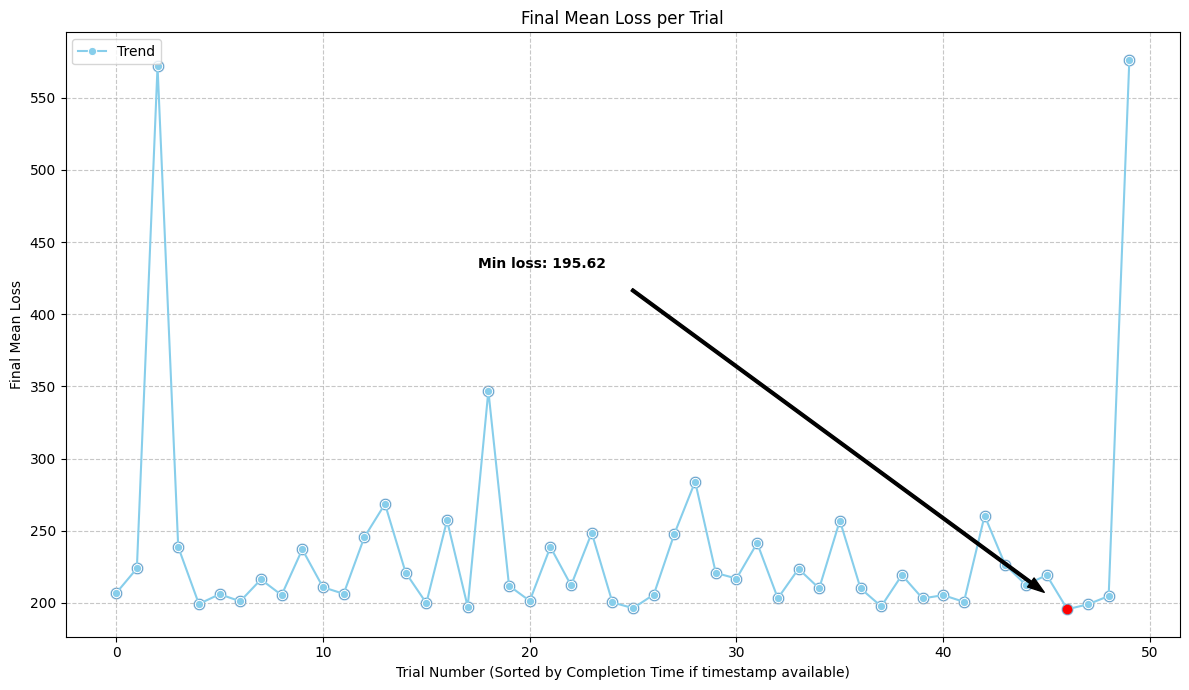


Best mean_loss: 195.6208 (occurred at trial number 46 in this plot)
Corresponding config for the overall best trial:
{'lr': 2.749878861226148e-05, 'batch_size': 8, 'epochs': 100, 'hidden_size': 283, 'weight_decay': 3.689504249610589e-05, 'num_layers': 6}


In [ ]:
# 1. Get the results as a DataFrame
# This DataFrame contains one row per trial, with the *last reported* metrics.
df_results = results.get_dataframe()

# 2. Identify the metric column
best_result_check = results.get_best_result(metric="mean_loss", mode="min")

metric_to_plot = 'mean_loss'

# 3. Filter out errored trials (optional, but good practice)
if 'error' in df_results.columns:
    df_successful_trials = df_results[df_results["error"].isna()].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Filtered out {len(df_results) - len(df_successful_trials)} errored trials based on 'error' column.")
else:
    # If neither 'error' nor 'error_filename' column is present, assume all trials were successful
    print("Warning: Neither 'error' nor 'error_filename' column found. Assuming all trials were successful for plotting.")
    df_successful_trials = df_results.copy() # Use .copy()

# Ensure 'trial_number' is created regardless of sorting success
df_successful_trials["trial_number"] = np.arange(len(df_successful_trials))

# 5. Create the plot
plt.figure(figsize=(12, 7))

# Scatter plot of loss vs. trial number
sns.scatterplot(
    data=df_successful_trials,
    x="trial_number",
    y=metric_to_plot,
    alpha=0.7,
    s=80 # size of points
)

# Line plot to see trends (optional)
sns.lineplot(
    data=df_successful_trials,
    x="trial_number",
    y=metric_to_plot,
    marker="o", # add markers to the line plot
    color="skyblue",
    label="Trend"
)
best_trial_value = df_successful_trials[metric_to_plot].min() # Assuming mode='min'
best_trial_ind = df_successful_trials[df_successful_trials[metric_to_plot] == best_trial_value]["trial_number"].iloc[0]

plt.scatter(best_trial_ind, best_trial_value, color='red', zorder=5)
plt.annotate(f'Min loss: {best_trial_value:.2f}',
                     xy=(best_trial_ind, best_trial_value),
                     xytext=(0.35* len(df_successful_trials),0.75*df_successful_trials['mean_loss'].max()),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                     fontsize=10, color='black', fontweight='bold')

plt.title(f'Final {metric_to_plot.replace("_", " ").title()} per Trial')
plt.xlabel('Trial Number (Sorted by Completion Time if timestamp available)')
plt.ylabel(f'Final {metric_to_plot.replace("_", " ").title()}')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# You can also highlight the best trial
best_trial_value = df_successful_trials[metric_to_plot].min() # Assuming mode='min'
best_trial_number = df_successful_trials[df_successful_trials[metric_to_plot] == best_trial_value]["trial_number"].iloc[0]

print(f"\nBest {metric_to_plot}: {best_trial_value:.4f} (occurred at trial number {best_trial_number} in this plot)")
print("Corresponding config for the overall best trial:")
best_config = results.get_best_result(metric=metric_to_plot, mode="min").config
print(best_config)

In [ ]:
config={
    "lr": 2.749878861226148e-05,
    "batch_size": 8,
    "epochs": 100,
    "hidden_size": 283,
    "num_layers": 6,
    "weight_decay": 3.689504249610589e-05
}
train_loss_history, val_loss_history, best_model = train_linear_regression(config)

Start training with Num_epochs= 100
The best model is Found with validation loss= 8.8846e+02
Epoch [1/100] Train Loss: 1016.8257 - validation loss: 888.4624


/usr/local/lib/python3.11/dist-packages/ray/train/_internal/session.py:657: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


The best model is Found with validation loss= 1.9892e+02
Epoch [2/100] Train Loss: 395.7238 - validation loss: 198.9184
The best model is Found with validation loss= 1.9564e+02
Epoch [3/100] Train Loss: 218.3516 - validation loss: 195.6368
The best model is Found with validation loss= 1.9545e+02
Epoch [4/100] Train Loss: 218.6392 - validation loss: 195.4512
Epoch [5/100] Train Loss: 218.5601 - validation loss: 196.8050
The best model is Found with validation loss= 1.9539e+02
Epoch [6/100] Train Loss: 218.1760 - validation loss: 195.3924
Epoch [7/100] Train Loss: 218.6729 - validation loss: 197.2926
Epoch [8/100] Train Loss: 217.6849 - validation loss: 195.5645
Epoch [9/100] Train Loss: 219.1635 - validation loss: 197.8446
The best model is Found with validation loss= 1.9531e+02
Epoch [10/100] Train Loss: 218.9651 - validation loss: 195.3099
Epoch [11/100] Train Loss: 219.1346 - validation loss: 195.3901
Epoch [12/100] Train Loss: 217.6454 - validation loss: 196.2842
Epoch [13/100] Trai

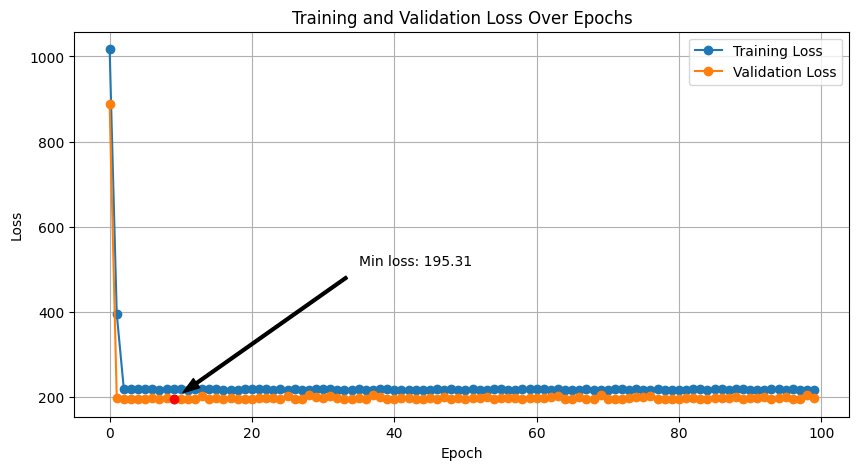

In [ ]:
# plotting losees history
def plot_loss_history(train_loss_history, val_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss', marker='o')
    plt.plot(val_loss_history, label='Validation Loss', marker='o')
    plt.scatter(val_loss_history.index(min(val_loss_history)) , min(val_loss_history), color='red', zorder=5)
    plt.annotate(f'Min loss: {min(val_loss_history):.2f}',
                 xy=(val_loss_history.index(min(val_loss_history)), min(val_loss_history)),
                 xytext=(0.35*len(val_loss_history),0.5*(max(train_loss_history))),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_history(train_loss_history, val_loss_history)

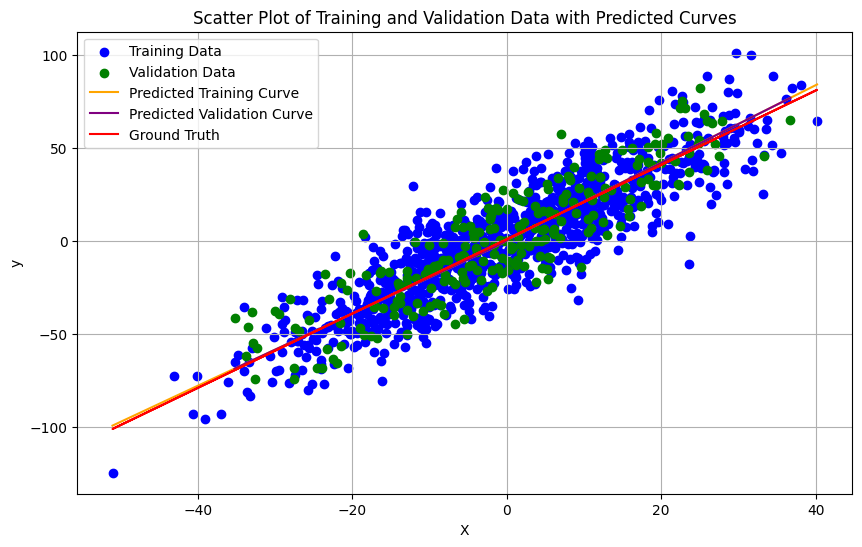

In [ ]:
# plotting the predected curve with the scattered data
def plot_prediction(X_train, y_train, X_val, y_val, model):
    """
    Plots the predicted curve with the scattered data.

    Args:
        X_train (torch.Tensor): Training data features.
        y_train (torch.Tensor): Training data labels.
        X_val (torch.Tensor): Validation data features.
        y_val (torch.Tensor): Validation data labels.
        model_state_dict (collections.OrderedDict): The state dictionary of the trained model.
        hidden_size (int): The hidden size used to create the model.
    """
    # Put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        y_pred_train = model(X_train.to(device)).cpu() # Move to device for prediction, then back to CPU for plotting
        y_pred_val = model(X_val.to(device)).cpu()   # Move to device for prediction, then back to CPU for plotting

    plt.figure(figsize=(10, 6))
    plt.scatter(X_train.numpy(), y_train.numpy(), label='Training Data', color='blue')
    plt.scatter(X_val.numpy(), y_val.numpy(), label='Validation Data', color='green')

    # Sort X values before plotting the line to avoid jagged lines
    train_sort_idx = X_train.argsort(dim=0).squeeze()
    val_sort_idx = X_val.argsort(dim=0).squeeze()

    plt.plot(X_train[train_sort_idx].numpy(), y_pred_train[train_sort_idx].numpy(), label='Predicted Training Curve', color='orange')
    plt.plot(X_val[val_sort_idx].numpy(), y_pred_val[val_sort_idx].numpy(), label='Predicted Validation Curve', color='purple')
    plt.plot(X_train.numpy(), 2 * X_train.numpy() + 1, color='red', label='Ground Truth')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Scatter Plot of Training and Validation Data with Predicted Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function with the state dict and hidden size
# Assuming 'config' is the dictionary used for the single run,
# and it contains the 'hidden_size' key.
# If you want to plot for the best model found by Ray Tune,
# you would need to get the config from results.get_best_result()
# and the best_model state dict from the checkpoint (if saved).
# For the single run example below, we use the 'config' and 'best_model' returned
# by the train_linear_regression function.
plot_prediction(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=best_model)